In [19]:
import re
import random
import pandas as pd
import hashlib

In [ ]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = .5
else: age_factor = 2

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(age_factor) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.1


cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [21]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Azure AI Search,541.749043,108.349809,305.670440,5
Email Auth and Security,2502.865000,208.572083,944.157616,12
Audit Report Tracker (Sharepoint List),4193.395572,322.568890,1282.048607,13
IW Migration,4297.119969,306.937141,1022.589457,14
Todd Ideas,4420.231071,294.682071,1079.597103,15
Debugging in VS Code,4433.135907,221.656795,723.935716,20
Open Source/GitHub,4487.847022,280.490439,1209.077570,16
Terraform,4734.268056,189.370722,750.325472,25
Python,4818.459192,102.520408,332.670527,47
DNS,4975.382303,497.538230,1317.396427,10


# Histogram

159309.97


<Axes: >

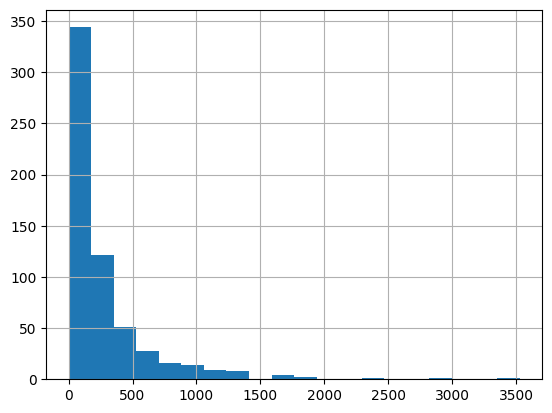

In [22]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [23]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [24]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [25]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [26]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [27]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [28]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [29]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [30]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [31]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)



## Age Max

In [32]:
n = 1
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

if existing_cards['age'].sum() > 0:
    existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 600


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
68,Logging in Python,Q: Which parameter in logging.basicConfig() fr...,17389fb76e3f239567cdcca3308d60b2,-3525.699701,293.777859,-3525.699701,14101.337249,0.343597,0,0
0,Home Network Project,Front: What is Docker Swarm and how does it di...,e9c23d755d0c0cd08842a9eeead3f3fd,-2834.039454,622.599285,-2834.039454,6225.992851,0.084848,0,0
8,SharePoint,How can you retrieve the metadata of a specifi...,a9bef1ae5a68637d2ee73d72c0aa7e47,-2463.440310,467.495971,-2463.440310,5609.951655,0.901824,0,0
135,Vocab,Lost in a Good Book\nBlagged (a ride): British...,58fe170527f490cd6f8c7008a49b29f1,-1868.005283,215.614453,-1868.005283,13583.710530,0.579717,0,0
111,Powershell Modules,Force Parameter (-Force)\n\nDefinition: A para...,86d61295fcc1174c9a68f619bac74243,-1815.185281,250.224982,-1815.185281,12261.024113,0.906748,0,0
12,Azure Functions + PP365,Client Credentials Grant\nAn OAuth 2.0 authent...,1cade23aa0a9cc7dc8067853d5c07f73,-1699.229942,398.434340,-1699.229942,9163.989819,0.587416,0,0
90,JavaScript Concepts,Fetch API / Axios: Tools for making HTTP reque...,4d9b07853e56c49e129ed710afd1c818,-1689.799952,254.908359,-1689.799952,15549.409925,0.349370,0,0
46,WSL + Kali Linux,wsl Command\nThe primary command-line interfac...,2ff6ec8cc28c0d5a7cf021f5b6848f5d,-1635.047415,325.212770,-1635.047415,6179.042636,0.346028,0,0
4,DNS,TSIG (Transaction SIGnature)\nA security mecha...,9e28948c765ca4a73ba92603308b6f86,-1317.396427,497.538230,-1317.396427,4975.382303,0.670953,0,0
53,Audit Report Tracker (Sharepoint List),Permissions (SharePoint Permissions)\nDefiniti...,478e966342056d5e8f7733388947e310,-1282.048607,322.568890,-1282.048607,4193.395572,0.576528,0,0


## Card Count

In [33]:
# n=10
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)




## Random

In [34]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [35]:
existing_cards.head(10).sum()

head                   Logging in PythonHome Network ProjectSharePoin...
body                   Q: Which parameter in logging.basicConfig() fr...
hash                   17389fb76e3f239567cdcca3308d60b2e9c23d755d0c0c...
age                                                        -20129.892372
subject_mean_age                                             3648.375141
subject_highest_age                                        -20129.892372
subject_age_sum                                             91843.236653
head_random_roll                                                5.347029
count                                                                  0
n_fold                                                                 0
dtype: object

In [36]:
existing_cards['age'].mean()

-265.5166167369188